In [1]:
pip install scipy


The following command must be run outside of the IPython shell:

    $ pip install scipy

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import pandas as pd
import seaborn as sns
import numpy as np

from scipy.optimize import curve_fit
from scipy.odr import ODR, Model, Data, RealData
from scipy.spatial.distance import jensenshannon

In [3]:
import warnings
warnings.filterwarnings('ignore')

# LOAD DATA from ANES 2016

The following code loads the ANES 2016 database, structured as follows:
- Each column corresponds to one question of the survey (including things like mode of interview, demographic data...), codified with a string mixing letters and numbers.
- Each row corresponds to one person.

Information about which question is represented by each code is given in the "anes_timeseries_2016_guidebook.pdf", which can be found in data/anes_timeseries_2016/ folder.

The coding method is a bit of a mess but there are some general ideas:
- The survey is taken both before and after the election, but questions are not necessarily the same. Pre-election questions start with "V161...", and post-election ones, with "V162...". Codes beginning with "V160..." correspond to technical information.
- When there are multiple possible answers in a question (religious identification, race...) each answer is usually codified as different by adding a letter to the code. For example, V161310 indicate self-identified race, and the answers are codified by V161310a: white; V161310b: black...
- In those cases, results are aggregated in a final code which includes the letter 'x' at the end. In the former case, V161310x includes all possible races.

Of special importance for our work are the questions about being in favor/opposite of certain policies. ANES has a singular way of making this kind of questions: First, it asks the respondant if he/she is in favor or against the policy. Then, it asks how much in favor or against it (the same code as the former question but adding a letter), and finally, they sumarize the results (the same code as before but with a letter x). For example, in the case of Building a wall with Mexico, first it is asked "Do you favor, oppose, or neither favor nos oppose building a wall on the U.S. border with Mexico?" (code V161196). Then, it is asked "Do you favor/oppose that \[a great deal, a moderate amount, a little\]?" (code V161196a). Finally, the summary is shown in code V161196x.

### A brief comment about representativity of surveys, just in case

Even though ANES (and pretty much any other survey) tries to take a representative sample of the whole american society, there are always some variations that make some demographic groups either over or underrepresented. For example, if black women between 18 and 35 years old with income between 20K-30K dollars represent 10% of american society, but only 8% of the ANES sample, then one must give more importance to their answers with respect to the rest of the sample so that the final results of the survey are truly representative of the american society. This process of weighting data is as complicated as it seems, but most surveys perform this treatment themselves and include it in the data in the form of weights for each individual.

In the ANES case, this information is codified in columns V160101 for the pre-election survey, and V160102 for the post-election one (Note that the sample varies a little between surveys, so the weights also change). There are more weights, but we are only interested in those two. Its application is straightforward: when computing histograms (or any other treatment), the answer of a given individual must be multiplied by his/her weight.

### Loading the database

In [5]:
filename = "Anes_2016/anes_timeseries_2016.dta"
df_raw_data = pd.read_stata(filename)
df_raw_data.head()


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa0 in position 7: invalid start byte

Below there is a little bit of information about the relevant questions (those that one could consider minimally polarized) that I've found in the ANES 2016. I think it is quite comprehensive (it took some time to build), but I haven't checked all the codes.

There is also information about the number of possible answers (or boxes) in each question. Ideally, we want either 6 or 7 boxes, so that we have more resolution about people's opinions. 4 boxes are too few to be able to perform a meaningful analysis.

## Checklist

President handling job: V161082x (4 boxes) \
President handling economy: V161083x (4 boxes) \
President handling foreing relations: V161084x (4 boxes) \
President handling healthcare: V161085x (4 boxes) \
Obamacare: V161114x (7 boxes) \
Voting as duty or choice: V161151x (7 boxes) \
Party identification: V161158x (7 boxes) \
Birthright citizenship: V161194x (7 boxes) \
Children brought illegally should be sent back: V161195x (6 boxes) \
Wall with Mexico: V161196x (7 boxes) \
Government assistance to blacks: V161198 (7 boxes) \
Affirmative action in the univerisites: V161204x (7 boxes) \
Send troops to fight ISIS: V161213x (7 boxes) \
Allow Syrian refugees: V161214x (7 boxes) \
Government action about rising temperatures: V161225x (7 boxes) \
Require employers to offer paid leave to new parents: V161226x (7 boxes) \
Service to same sex couples: V161227x (6 boxes) \
Transgender bathrooms: V161228x (6 boxes) \
Laws protecting homosexual job discrimination: V161229x (4 boxes) \
Death penalty: V161233x (4 boxes)

POST-ELECTION: 

Economic mobility compared to 20 yrs ago: V162136x (7 boxes) \
Vaccines at school: V162147x (7 boxes) \
Equal pay: V162150x (7 boxes) \
Benefits/risks of vaccinations: V162162x (7 boxes) \
Liberal/Conservative self-placement: V162171 (7 boxes) (NOT INCLUDED: negative betas sometimes) \
Free-trade agreements: V162176x (7 boxes) \
Government should regulate banks: V162180x (7 boxes) \
Government spending for healthcare: V162193x (7 boxes) \
Obama is a muslim: V162255x (9 boxes) (NOT INCLUDED for convenience) \
Torture for terrorists: V162295x (7 boxes)

# About format in the answers

Unfortunately, sociologists don't usually work with Python, but use other specific software. As a result, they are not very categorical with their data, meaning that the response format can vary from integers to floats and worst of all, strings. Therefore, before trying to work with the data one must usually convert all of those into integers or floats (when aplicable).

The following code extracts **some** of the relevant questions of the previous list into a new database ("df_data"), including the weights, and curates the data so that categorical responses are given as integers from 1 onwards, with the function "data_processor". We could maybe avoid this step, but then comparison between real-world and synthetic distributions might become very complicated. Note that answers in string format usually include the integer that correspond to each answer as the first digit of the string (e.g. "1. Favor a great deal" the construction of a will with Mexico).

**Important**: ANES is relatively consistent in that "1" usually means greatly in favor, but some questions have different kinds of answers (e.g. V161228x: Transgender policy, in which respondant chooses between "gender born" or "gender identified" instead of "favor" or "oppose"). Nevertheless, even when the questions have "favor/oppose" answers, responses can be easily misinterpreted. Take, for example, the issues "Wall with Mexico" (V161196x) and "Birthright citizenship" (V161193x). In those cases, "1" has the meaning "In favor of constructing a wall with Mexico" (leaning republican), but also "Favor birthright citizenship" (leaning democrat). This will become very relevant when we try to compare real opinion distributions with synthetic ones, and will probably need some further data curation.

Some considerations: if a response is not given, then a '0' is assigned. Some responses have negative numbers (e.g. "-8. Don't know", "-9. refused to answer"...), and those are also assigned a '0'. Finally, it is assumed that only integers below 9 are used. This is true for most questions, as there are usually no more than 8 answers, but not in all of them. Maybe the most representative cases are the "feeling thermometer" from 0 to 100 (V161086 to V161096, and V162078 to V162113). Regardless, none of the questions included in the former list incur in this problem.

In [4]:
def data_processor(x):
    if(isinstance(x, int)):
        return x
    elif(isinstance(x, float)):
        return int(x)
    elif(isinstance(x, str)):
        return int(x[0]) if(x[0]!="-" and int(x[0])<9) else 0
    elif(x.isnan()):
        return 0
    else:
        print("Error, no se ha identificado el tipo: {}".format(type(x)))


# Brief description of the codes
dict_labels = {'V161114x':'Obamacare','V161151x':'Voting as duty or choice','V161158x':'Party identification', 
               'V161194x':'Birthright citizenship','V161195x':'Illegal-coming children sent back',
               'V161196x':'Build wall with Mexico','V161198':'Government assistance to blacks',
               'V161204x':'Affirmative action in the universities','V161213x':'Send troops to fight ISIS',
               'V161214x':'Allow Syrian refugees','V161225x':'Government action about rising temp.',
               'V161226x':'Employers to offer paid leave to parents','V161227x':'Allow to refuse service to same-sex couples',
               'V161228x':'Transgender bathroom use', 'V162136x':'Econ. mobility compared to 20 yrs ago',
               'V162147x':'Vaccines at school','V162150x':'Equal pay','V162162x':'Benefits of vaccin. outweight risks',
               'V162171':'Liberal/conservative self-placement (post)','V162176x':'Free-trade agreements',
               'V162180x':'Government should regulate banks','V162193x':'Government spending for healthcare','V162295x':'Torture for terrorists'
               }
        
# Questions from the pre-election survey
labels_pre = ['V161082x','V161083x','V161084x','V161085x','V161114x','V161151x','V161158x','V161194x','V161195x',
               'V161196x','V161198','V161204x','V161213x','V161214x','V161225x','V161226x','V161227x','V161228x',
               'V161229x','V161233x']
# Questions from the post-election survey
labels_post = ['V162136x','V162147x','V162150x','V162162x','V162171','V162176x','V162180x','V162193x','V162295x']
        
labels = labels_pre + labels_post

# Questions with 7 boxes
labels_7 = ['V161114x','V161151x','V161158x','V161194x','V161196x','V161198','V161204x','V161213x','V161214x',
            'V161225x','V161226x','V162136x','V162147x','V162150x','V162162x','V162176x',
            'V162180x','V162193x','V162295x']
# Questions with 6 boxes
labels_6 = ['V161195x','V161227x', 'V161228x']

# Weights:
# V160101 for pre-election data
# V160102 for post-election data

df_data_aux = df_raw_data[labels]
df_data = pd.DataFrame()

for code in labels:
    df_data[code] = df_data_aux[code].apply(data_processor)
    
df_data[['V160101','V160102']] = df_raw_data[['V160101','V160102']]
               
df_data.head()


,V161082x,V161083x,V161084x,V161085x,V161114x,V161151x,V161158x,V161194x,V161195x,V161196x,...,V162147x,V162150x,V162162x,V162171,V162176x,V162180x,V162193x,V162295x,V160101,V160102
0,4,4,4,4,7,4,7,4,5,1,...,2,2,4,6,2,2,4,4,0.8270,0.8420
1,4,0,0,4,4,4,6,1,5,1,...,1,1,1,5,4,4,2,7,1.0806,1.0133
2,4,4,4,4,2,6,3,7,2,6,...,1,1,5,0,6,2,2,1,0.3878,0.3672
3,4,4,3,4,6,7,5,4,5,4,...,4,2,4,6,4,4,6,4,0.3596,0.3663
4,3,4,3,4,4,5,3,6,6,7,...,4,1,2,4,4,4,7,4,0.6470,0.6463


# Representation

## Seaborn
With this data, we can easily plot all histograms with Seaborn (remember the weights): 

La pregunta que elegí ver es:  Benefits of vaccin. outweight risks


<AxesSubplot: xlabel='V162162x', ylabel='Count'>

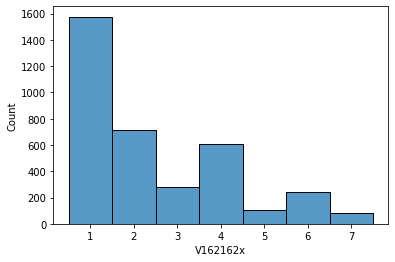

In [5]:
code = 'V162162x' # Birthright Citizenship
weights = 'V160101'

print("La pregunta que elegí ver es: ",dict_labels[code])

sns.histplot(df_data.loc[df_data[code]>0], x=code, weights=weights, discrete=True)

With two issues at the same time (note the apparent 'inverse ideology', as the most populated boxes are the upper left and lower right, because of the responses formulation):

**(note) In the following we only consider individuals with a meaninful response in both issues.**

Text(0, 0.5, 'Benefits of vaccin. outweight risks')

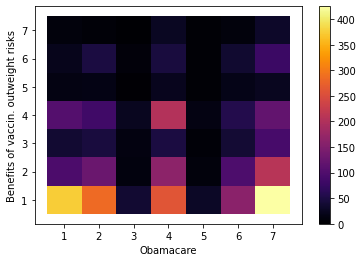

In [12]:
code_1 = 'V161114x' # Wall with Mexico
code_2 = 'V162162x' # Birthright citizenship
weights = 'V160101'

df_aux = df_data.loc[(df_data[code_1]>0) & (df_data[code_2]>0)]

sns.histplot(df_aux, x=code_1, y=code_2, weights=weights, discrete=True, cbar=True, cmap='inferno')

plt.xlabel(dict_labels[code_1])
plt.ylabel(dict_labels[code_2])

# plt.gca().invert_yaxis()

# print("El código del eje X es: ",dict_labels[code_1])
# print("El código del eje Y es: ",dict_labels[code_2])

Just to show off, we can also get easily:

El código del eje X es:  Party identification
El código del eje Y es:  Benefits of vaccin. outweight risks


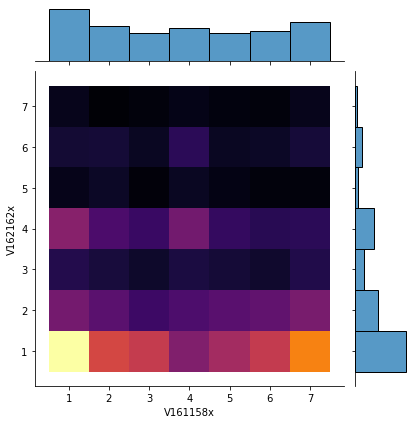

In [8]:
code_1 = 'V161158x' # Wall with Mexico
code_2 = 'V162162x' # Birthright citizenship
weights = 'V160101'

df_aux = df_data.loc[(df_data[code_1]>0) & (df_data[code_2]>0)]

sns.jointplot(df_aux, x=code_1, y=code_2, kind="hist", vmin=0, cmap='inferno',
              joint_kws={'discrete': True, 'weights': df_aux[weights]}, 
              marginal_kws={'discrete': True, 'weights': df_aux[weights]})

# plt.gca().invert_yaxis()

print("El código del eje X es: ",dict_labels[code_1])
print("El código del eje Y es: ",dict_labels[code_2])

## Matplotlib

It works, but could become a little cumbersome depending on the plot (see, for example, the range needed to correctly capture the bins in the 1D scenario, but also on 2D, which is disgusting and made me feel ashamed of myself).

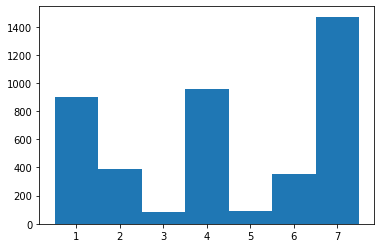

In [9]:
code = 'V161196x' # Wall with Mexico
weights = 'V160101'

df_aux = df_data.loc[df_data[code]>0]

hist, edges, fig = plt.hist(x=df_aux[code], weights=df_aux[weights],
         bins=np.arange(df_aux[code].min(), df_aux[code].max()+2, 1), align='left')

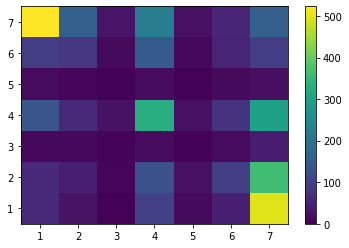

In [10]:
code_1 = 'V161196x' # Wall with Mexico
code_2 = 'V161114x' # Birthright citizenship
weights = 'V160101'

df_aux = df_data.loc[(df_data[code_1]>0) & (df_data[code_2]>0)]

hist2d, xedges, yedges, im = plt.hist2d(x=df_aux[code_1], y=df_aux[code_2], weights=df_aux[weights], vmin=0,
         bins=[np.arange(df_aux[code_1].min()-0.5, df_aux[code_1].max()+1.5, 1), np.arange(df_aux[code_2].min()-0.5, df_aux[code_2].max()+1.5, 1)])

plt.colorbar(im)

On the positive side, it also gives back the histogram, which we will need to make comparisons with our synthetic results.

In [11]:
print(hist2d)

[[ 60.9233  57.7185  10.4992 138.0466  15.9463  92.5951 523.0534]
 [ 25.4241  43.6283  10.8046  60.7244   8.8692  83.6373 158.5334]
 [  2.6355   8.0317   4.302   22.6036   3.604   14.2491  26.8464]
 [ 99.381  129.2703  14.8994 327.6836  15.792  150.4226 219.5452]
 [ 12.969   20.7714   2.9995  21.5132   2.5139  10.3734  21.8386]
 [ 45.1193  93.5818  15.0073  76.3261  13.6039  51.803   54.2341]
 [497.0053 362.568   42.6478 298.5776  18.4315  94.9581 155.4662]]
